In [ ]:
# Установим пакет ucimlrepo
!pip install ucimlrepo

# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Загружаем датасет
mushroom = fetch_ucirepo(id=73)

# Данные
X = mushroom.data.features  # Признаки
y = mushroom.data.targets   # Целевая переменная

# Преобразуем целевую переменную в бинарный формат (0 и 1)
y = y.iloc[:, 0].map({'p': 1, 'e': 0})

# Проверяем результат
print("Признаки (X):")
print(X.head())

print("\nЦелевая переменная (y):")
print(y.head())

Признаки (X):
  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         n          k           e  ...                        s   
1         b          k           e  ...                        s   
2         b          n           e  ...                        s   
3         n          n           e  ...                        s   
4         b          k           t  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w      

In [ ]:
#Отбор случаных признаков
# Вычисляем количество признаков для отбора
n_features = int(np.sqrt(X.shape[1]))

# Случайным образом отбираем признаки
selected_features = np.random.choice(X.columns, size=n_features, replace=False)
X_selected = X[selected_features]

In [ ]:
#Реализация дерева решений
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def gini(self, y):
        """Вычисляет индекс Джини для целевой переменной."""
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def split(self, X, y, feature, threshold):
        """Разделяет данные по признаку и пороговому значению."""
        left_mask = X[feature] <= threshold
        right_mask = X[feature] > threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def find_best_split(self, X, y):
        """Находит лучшее разделение данных."""
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = np.unique(X[feature])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self.split(X, y, feature, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gini = (len(y_left) * self.gini(y_left) + len(y_right) * self.gini(y_right)) / len(y)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        """Рекурсивно строит дерево решений."""
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            return np.argmax(np.bincount(y))

        feature, threshold = self.find_best_split(X, y)
        if feature is None:
            return np.argmax(np.bincount(y))

        X_left, X_right, y_left, y_right = self.split(X, y, feature, threshold)
        left_subtree = self.build_tree(X_left, y_left, depth + 1)
        right_subtree = self.build_tree(X_right, y_right, depth + 1)

        return {'feature': feature, 'threshold': threshold,
                'left': left_subtree, 'right': right_subtree}

    def fit(self, X, y):
        """Обучает дерево решений."""
        self.tree = self.build_tree(X, y)

    def predict_sample(self, sample, tree):
        """Предсказывает класс для одного образца."""
        if not isinstance(tree, dict):
            return tree
        feature = tree['feature']
        threshold = tree['threshold']
        if sample[feature] <= threshold:
            return self.predict_sample(sample, tree['left'])
        else:
            return self.predict_sample(sample, tree['right'])

    def predict(self, X):
        """Предсказывает класс для всех образцов."""
        return np.array([self.predict_sample(row, self.tree) for _, row in X.iterrows()])

In [ ]:
#Оценка алгоритма
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives > 0 else 0

def recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives > 0 else 0

# Обучаем дерево
tree = DecisionTree(max_depth=5)
tree.fit(X_selected, y)

# Предсказываем
y_pred = tree.predict(X_selected)

# Оцениваем
print("Accuracy:", accuracy(y, y_pred))
print("Precision:", precision(y, y_pred))
print("Recall:", recall(y, y_pred))

Accuracy: 0.9911373707533235
Precision: 0.9938335046248715
Recall: 0.9877425944841676


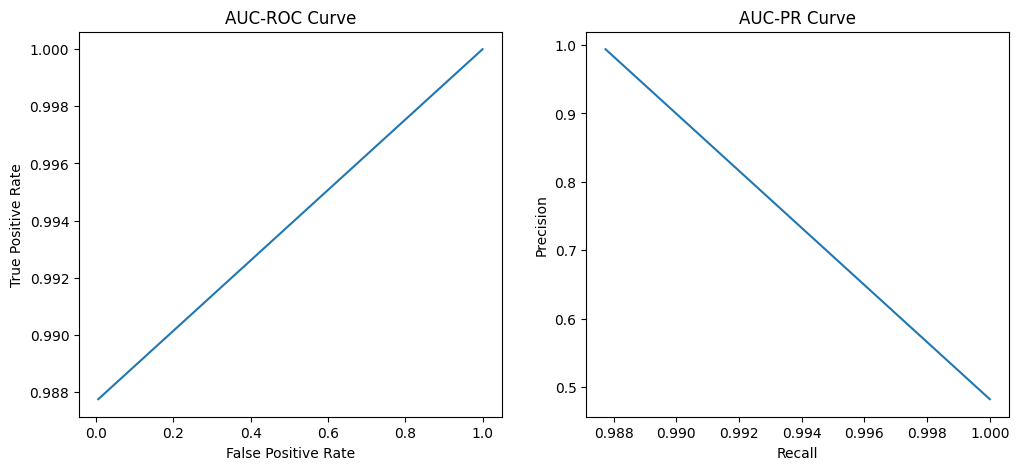

In [ ]:
# Построение кривых AUC-ROC и AUC-PR
def roc_curve(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    tpr = []
    fpr = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))
        true_negatives = np.sum((y_true == 0) & (y_pred == 0))
        false_negatives = np.sum((y_true == 1) & (y_pred == 0))

        tpr.append(true_positives / (true_positives + false_negatives))
        fpr.append(false_positives / (false_positives + true_negatives))

    return fpr, tpr, thresholds

def pr_curve(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    precision = []
    recall = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        predicted_positives = np.sum(y_pred == 1)
        actual_positives = np.sum(y_true == 1)

        precision.append(true_positives / predicted_positives if predicted_positives > 0 else 0)
        recall.append(true_positives / actual_positives if actual_positives > 0 else 0)

    return recall, precision, thresholds

# Пример использования
fpr, tpr, _ = roc_curve(y, y_pred)
recall_pr, precision_pr, _ = pr_curve(y, y_pred)

# Построение графиков (используем matplotlib для визуализации)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# AUC-ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")

# AUC-PR
plt.subplot(1, 2, 2)
plt.plot(recall_pr, precision_pr, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUC-PR Curve")

plt.show()